In [1]:
import os
import sys
import warnings
import cv2 as cv

import numpy as np
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

In [25]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
IM_PATH = "LISC_Segmentation/Main_Dataset/"
LABEL_PATH = "LISC_Segmentation/Ground_Truth_Segmentation/"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 13
random.seed = seed
np.random.seed = seed

cells = ["Basophil", "Lymphocyte", "Eosinophil", "Monocyte", "Neutrophil"]

In [26]:
IMG = []
LABELS = []

In [27]:
for celltype in cells:
    print("Processing: {}".format(celltype))
    for img in tqdm(os.listdir(LABEL_PATH + celltype)):
        if ".bmp" not in img:
            continue
        else:
            mask = cv.imread(LABEL_PATH + celltype + "/" + img, cv.IMREAD_GRAYSCALE)
            img = cv.imread(IM_PATH + celltype + "/" + img.split("_")[0] + ".bmp")
            mask = cv.resize(mask.astype(np.uint8), (IMG_WIDTH, IMG_HEIGHT)) > 0
            img = cv.resize(img.astype(np.uint8), (IMG_WIDTH, IMG_HEIGHT))
#             plt.imshow(mask)
#             plt.show()
#             plt.imshow(img)
#             plt.show()
            LABELS.append(mask)
            IMG.append(img)
        
    
    
    

  0%|          | 0/39 [00:00<?, ?it/s]

Processing: Basophil
Processing: Lymphocyte
Processing: Eosinophil


100%|██████████| 50/50 [00:00<00:00, 539.22it/s]

Processing: Monocyte
Processing: Neutrophil


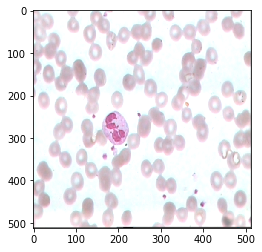

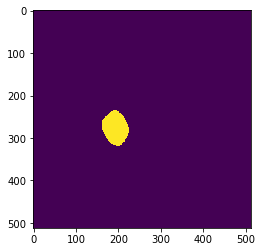

In [28]:
plt.imshow(IMG[228])
plt.show()
plt.imshow(LABELS[228])
plt.show()

In [29]:
IMG[220]

array([[[204, 194, 195],
        [222, 212, 213],
        [213, 203, 204],
        ...,
        [206, 204, 204],
        [166, 164, 164],
        [107, 107, 107]],

       [[211, 194, 196],
        [230, 212, 214],
        [221, 202, 204],
        ...,
        [209, 199, 200],
        [168, 161, 162],
        [107, 104, 105]],

       [[213, 195, 196],
        [233, 213, 215],
        [224, 202, 204],
        ...,
        [209, 197, 198],
        [168, 159, 159],
        [108, 103, 103]],

       ...,

       [[184, 169, 175],
        [221, 201, 208],
        [226, 199, 208],
        ...,
        [146, 144, 139],
        [127, 125, 121],
        [ 95,  93,  90]],

       [[108, 103, 104],
        [125, 117, 119],
        [126, 116, 118],
        ...,
        [ 65,  67,  64],
        [ 62,  64,  62],
        [ 58,  60,  59]],

       [[ 53,  56,  51],
        [ 53,  57,  52],
        [ 53,  57,  52],
        ...,
        [ 49,  55,  50],
        [ 49,  55,  50],
        [ 49,  55,  50]]

In [30]:
IMG = np.array(IMG)

In [31]:
LABELS = np.array(LABELS)

In [32]:
inputs = Input((512, 512, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 512, 512, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 512, 512, 16) 448         lambda_8[0][0]                   
__________________________________________________________________________________________________
dropout_50 (Dropout)            (None, 512, 512, 16) 0           conv2d_104[0][0]                 
____________________________________________________________________________________________

In [38]:
model.fit(IMG, LABELS, validation_split=0.1, batch_size=10, epochs=100)

Train on 217 samples, validate on 25 samples
Epoch 1/100
217/217 [==============================] - 10s 48ms/sample - loss: 0.0021 - acc: 0.9991 - val_loss: 0.0058 - val_acc: 0.9984
Epoch 2/100
217/217 [==============================] - 10s 48ms/sample - loss: 0.0021 - acc: 0.9991 - val_loss: 0.0048 - val_acc: 0.9984
Epoch 3/100
217/217 [==============================] - 10s 48ms/sample - loss: 0.0020 - acc: 0.9991 - val_loss: 0.0050 - val_acc: 0.9984
Epoch 4/100
217/217 [==============================] - 10s 48ms/sample - loss: 0.0019 - acc: 0.9992 - val_loss: 0.0048 - val_acc: 0.9984
Epoch 5/100
217/217 [==============================] - 10s 48ms/sample - loss: 0.0020 - acc: 0.9992 - val_loss: 0.0046 - val_acc: 0.9985
Epoch 6/100
217/217 [==============================] - 10s 48ms/sample - loss: 0.0019 - acc: 0.9992 - val_loss: 0.0056 - val_acc: 0.9983
Epoch 7/100
217/217 [==============================] - 10s 48ms/sample - loss: 0.0020 - acc: 0.9992 - val_loss: 0.0059 - val_acc: 0.9

KeyboardInterrupt: 

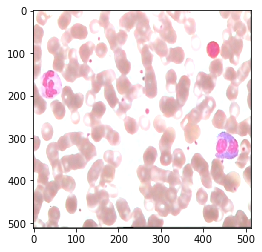

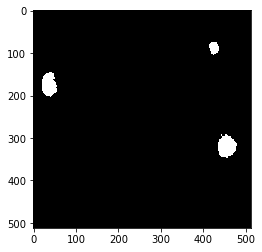

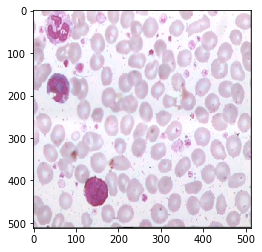

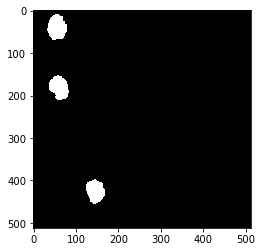

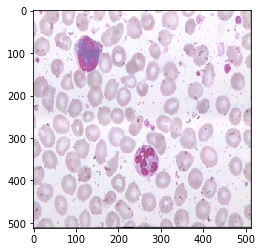

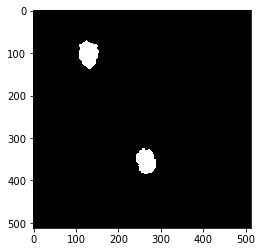

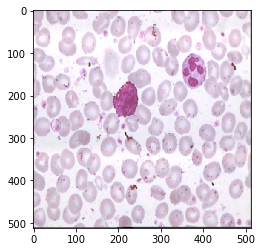

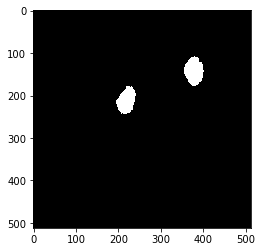

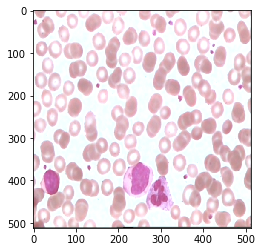

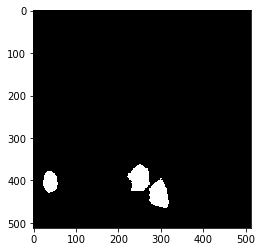

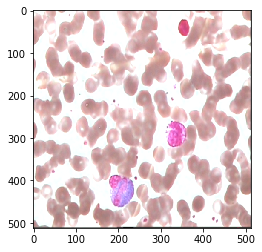

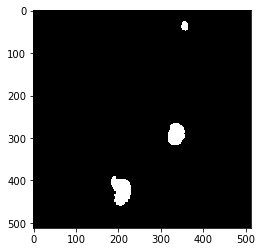

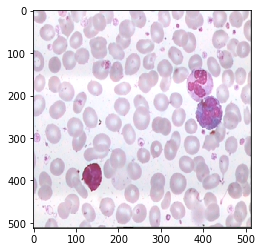

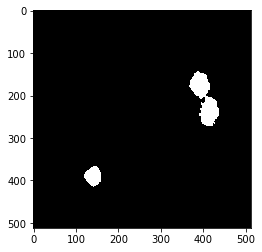

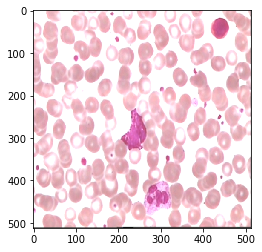

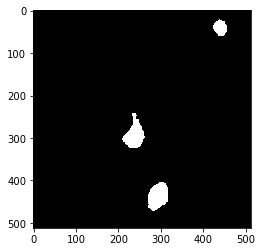

In [40]:
for i in os.listdir("test/"):
    if ".bmp" in i:
        img = cv.imread("test/" + i)
        img = cv.resize(img.astype(np.uint8), (IMG_WIDTH, IMG_HEIGHT))
#         print(img.shape)
        pred = model.predict(np.array([img]))[0].astype(np.uint8)
        pred = pred[:, :, 0]
#         print(np.max(pred))
        plt.imshow(img)
        plt.show()
        plt.imshow(pred, cmap="gray")
        plt.show()

In [41]:
model.save_weights("weights/first_iteration512.h5")